In [ ]:
# This notebook has been run on Google Colab. To run it, uncomment the following lines

# !rm -r Few-shot-learning-with-HuBERT
# !git clone -b speech_commands --single-branch \
# https://github.com/luckyman94/Few-shot-learning-with-HuBERT.git

# !pip install -U kagglehub



rm: cannot remove 'Few-shot-learning-with-HuBERT': No such file or directory
Cloning into 'Few-shot-learning-with-HuBERT'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 157 (delta 57), reused 139 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (157/157), 1.49 MiB | 4.60 MiB/s, done.
Resolving deltas: 100% (57/57), done.
rm: cannot remove 'kagglehub_cache/': No such file or directory


In [ ]:
import os
import sys
from pathlib import Path
import torch

# ---- Hugging Face token ----
# Uncomment the following line if you want to run the notebook on Google Colab. Make sure to replace "YOUR
#os.environ["HF_TOKEN"] = "YOUR TOKEN HERE"

# Uncomment the following lines if you want to run the notebook on Google Colab
#ROOT = Path.cwd() / "Few-shot-learning-with-HuBERT"
#sys.path.append(str(ROOT))

assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))


# ---- Project imports ----
from transformers import HubertModel
from src.datasets.speech_commands import SpeechCommandsDataset
from src.methods.fewshot.benchmark import benchmark_fewshot
from src.evaluation.evaluate import evaluate_benchmark
from src.methods.fewshot.sampling import sample_task
from src.methods.fewshot.prototypical import compute_prototypes, classify
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Example : 1 experiment

In [3]:
dataset = SpeechCommandsDataset()

print("Classes :", dataset.classes)
print("Nombre total de fichiers :", len(dataset))

x, y = dataset[0]
print(x.shape, y)



100%|██████████| 349M/349M [00:01<00:00, 214MB/s]

Extracting files...


[INFO] Building balanced dataset: 142 samples × 7 classes = 994
[INFO] Final dataset: 994 samples (142 per class)
Classes : ['down', 'left', 'off', 'on', 'right', 'stop', 'up']
Nombre total de fichiers : 994
torch.Size([16000]) 3


In [4]:
labels = [dataset[i][1] for i in range(len(dataset))]
print(Counter(labels))


Counter({3: 142, 1: 142, 5: 142, 4: 142, 0: 142, 6: 142, 2: 142})


In [5]:
X = []
y = []

for waveform, label in dataset:
    X.append(waveform)
    y.append(label)

X = torch.stack(X)
y = torch.tensor(y)


print(X.shape)
print(y.shape)


torch.Size([994, 16000])
torch.Size([994])


In [6]:
X_support, y_support, X_query, y_query = sample_task(
    X,
    y,
    n_way=10,
    k_shot=1,
    n_query=20
)


In [7]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

In [8]:
prototypes, proto_labels = compute_prototypes(
    hubert, X_support, y_support, device=device
)

preds = classify(
    hubert, X_query, prototypes, proto_labels, device=device
)

acc = (preds.cpu() == y_query).float().mean()
print("Few-shot accuracy:", acc.item())


Few-shot accuracy: 0.4000000059604645


## Benchmark

In [9]:
results = {}
for k in [1,5,10]:
    results[k] = benchmark_fewshot(model=hubert, X=X, y=y, device=device, k_shot=k, n_tasks=10)


10-shot benchmark: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]



===== Few-shot evaluation summary =====

--- 1-shot ---
Accuracy : 0.5320 ± 0.0749
F1 macro : 0.5366


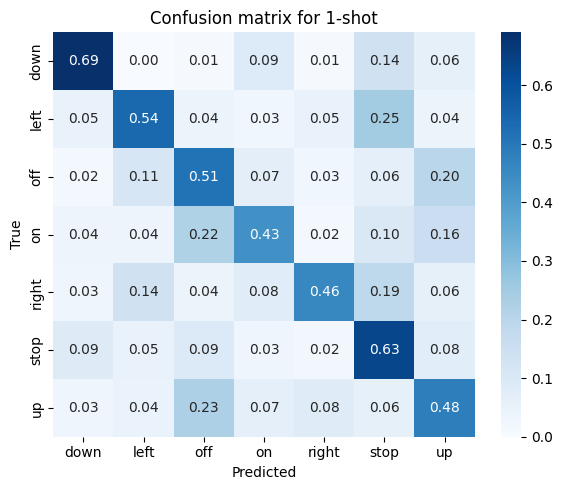


=== Evaluation metrics ===
accuracy    : 0.5320
f1_macro    : 0.5366
precision_macro: 0.5450
recall_macro: 0.5360


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


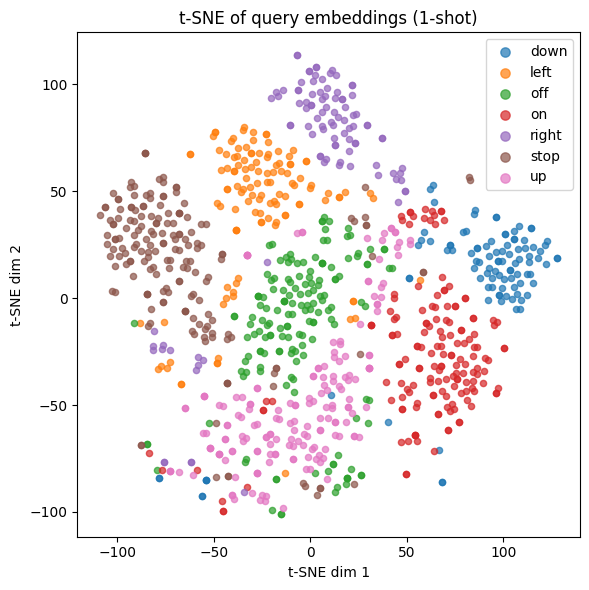


--- 5-shot ---
Accuracy : 0.8410 ± 0.0647
F1 macro : 0.8398


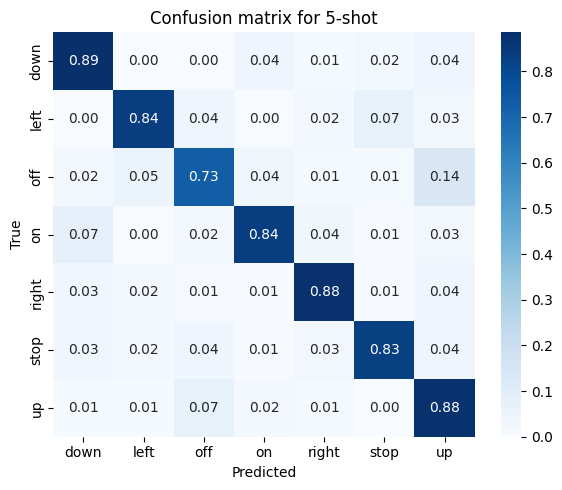


=== Evaluation metrics ===
accuracy    : 0.8410
f1_macro    : 0.8398
precision_macro: 0.8427
recall_macro: 0.8404


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


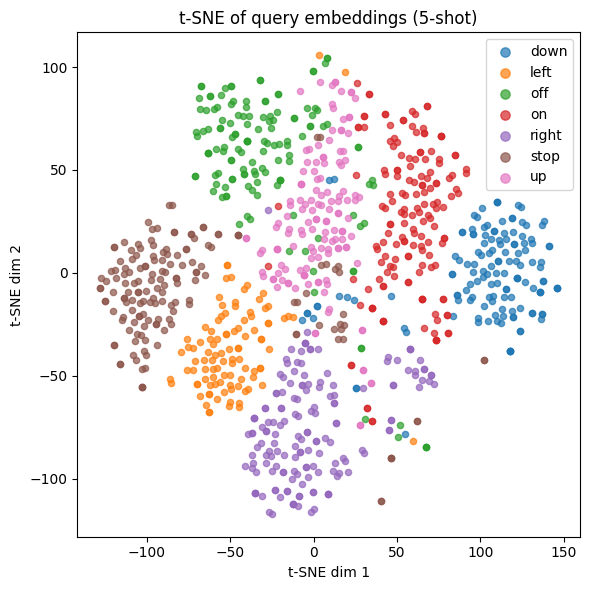


--- 10-shot ---
Accuracy : 0.8750 ± 0.0498
F1 macro : 0.8737


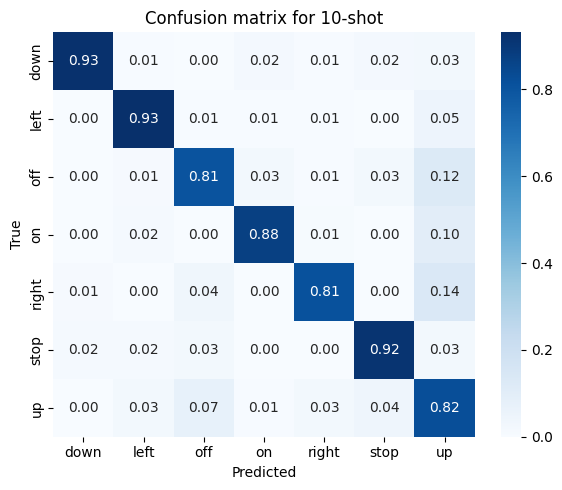


=== Evaluation metrics ===
accuracy    : 0.8750
f1_macro    : 0.8737
precision_macro: 0.8802
recall_macro: 0.8702


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


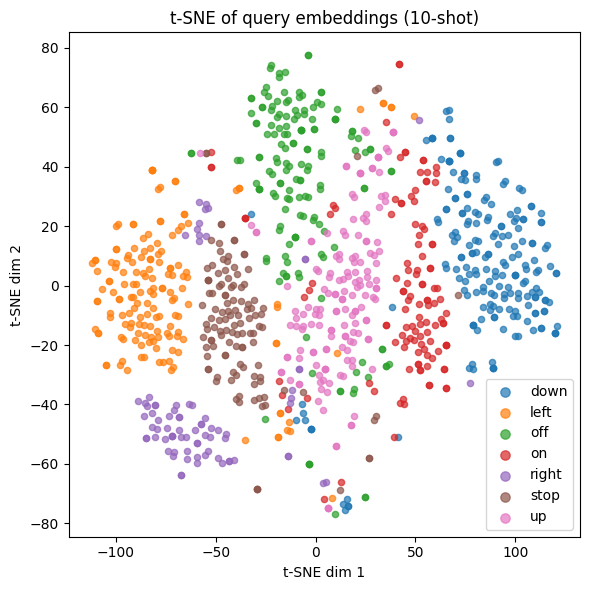

In [10]:
evaluate_benchmark(results, class_names=dataset.classes)